In [1]:
# --- PyTorch
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
# --- NetworkX
import networkx as nx
# --- RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
# --- MatPlotLib
import matplotlib.pyplot as plt
# --- Local modules
from create_dataset import XASDataset
from GNN import GNN
from utils.model import train_model, val_test

In [2]:
print(f'PyTorch version: {torch.__version__}')
print(f'PyG version: {torch_geometric.__version__}')

PyTorch version: 2.4.1+cpu
PyG version: 2.5.3


##### Import dataset

In [3]:
# --- Path to raw directory
path = "./"
# --- Create and load the dataset
dataset = XASDataset(path)

/home/samjhall/miniconda3/envs/pyg-schnet/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) an

Total number of molecules: 125833


Done!
/home/samjhall/github/QM9_charge/create_dataset.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


In [4]:
# --- Show details of the dataset
print(dataset)
print('-----------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')
# --- Show details of the first molecule/graph in the dataset
data = dataset[0]
print(data)
print('-----------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_directed()}')

XASDataset(125833)
-----------
Number of graphs: 125833
Number of features: 10
Number of classes: 0

Data(x=[9, 10], edge_index=[2, 18], edge_attr=[18, 4], spectrum=[300], idx=[1], smiles='Cc1conc1C(C)C')
-----------
Number of nodes: 9
Number of edges: 18
Average node degree: 2.00
Has isolated nodes: False
Has self loops: False
Is undirected: False


##### View data

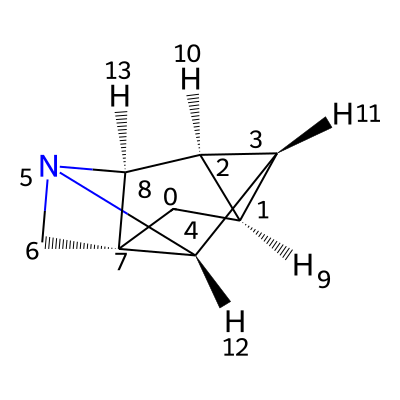

In [4]:
# --- View molecule using RDKit
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400, 400
mol = Chem.MolFromSmiles('C1[C@H]2[C@@H]3[C@H]2[C@H]2N4C[C@]12[C@H]34')
mol

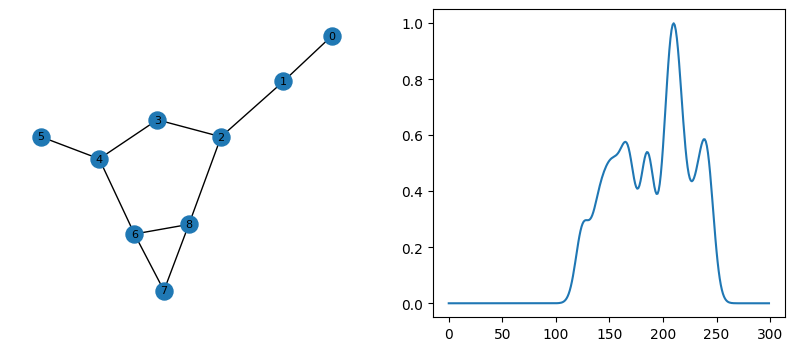

In [7]:
# --- Create subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# --- Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)
nx.draw(mol_graph, ax=ax1, with_labels=True, node_size=150, font_size=8)
# --- Show molecule spectrum
ax2.plot(data.spectrum)
plt.show()

##### Split up dataset

In [8]:
# --- Split data into test, validation and test
train_dataset = dataset[0:100667]
val_dataset = dataset[100667:113250]
test_dataset = dataset[113250:125834]
# --- Pass into dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
# --- Print loader details
print(f'Train loader length: {len(train_loader.dataset)}, with {len(train_loader)} batches')
print(f'Validation loader length: {len(val_loader.dataset)}, with {len(val_loader)} batches')
print(f'Train loader length: {len(test_loader.dataset)}, with {len(test_loader)} batches')

Train loader length: 100667, with 787 batches
Validation loader length: 12583, with 99 batches
Train loader length: 12584, with 99 batches


##### Set up GNN

In [9]:
# --- Define GNN properties
num_tasks = 300
num_layers = 3
in_channels = [dataset.num_features, 64, 128]
out_channels = [64, 128, 256]
gnn_type = 'gcn'
heads = 1
drop_ratio = 0.5
graph_pooling = 'mean'

In [13]:
# --- Select device to train model on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# --- Set seed for model for reproducibility
torch.manual_seed(1994)
# --- Create GNN
model = GNN(
    num_tasks,
    num_layers,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling
).to(device)
# --- View model details
print(model)
print('----------')
print(f'Training will be performed on: {device}')

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(10, 64)
      (1): GCNConv(64, 128)
      (2): GCNConv(128, 256)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=256, out_features=300, bias=True)
)
----------
Training will be performed on: cpu


##### Model settings

In [16]:
# --- Set model optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01,
                             betas=(0.9, 0.999), 
                             eps=1e-08,
                             amsgrad=True)
# --- Set optmizer scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=0.5,
                                                       patience=100,
                                                       min_lr=0.000001)

##### Run GNN training

In [ ]:
# --- Number of epochs
num_epochs = 300
# --- Empty list to store loss values
train_losses = []
val_losses = []
# --- Run model
for epoch in range(num_epochs):
    # --- Run a forward pass
    loss = train_model(model, train_loader, optimizer, device)
    # --- Calculate validation error
    val_error = val_test(model, val_loader, device)
    # --- Apply scheduler
    scheduler.step(val_error)
    # --- Add losses to lists
    train_losses.append(loss)
    val_losses.append(val_error)
    # --- Get the current lr
    current_lr = optimizer.param_groups[0]["lr"]
    # --- Print out status of the training
    if epoch % 25 == 0:
        print(f'Epoch: {epoch:03d}, LR: {current_lr:.3f}, TrainLoss: {loss:.5f}, ValLoss: {val_error:.5f}')

print('------------------')
print(f'Final training loss value: {loss:.5f} and validation loss: {val_error:.5f}')